Let's get started! First up is our import pile, for both libraries and files

In [1]:
import pandas as pd
import xgboost as xg
import matplotlib.pyplot as plt
import numpy as np
import math
import shap
import sklearn

annual_yields = pd.read_csv('annual_yields.csv')
daily_observations = pd.read_csv('daily_observations.csv')
common_data = pd.read_csv('common_data.csv')

In [2]:
annual_yields.head()

,year,yield
0,1990,118.5
1,1991,108.6
2,1992,131.5
3,1993,100.7
4,1994,138.6


In [3]:
daily_observations.head()

,adm2_code,year,date,doy,met_avg_t,met_extreme_cold,met_extreme_hot1,met_extreme_hot2,met_gdd,met_max_rh,...,mod_lst_day,mod_lst_night,mod_nbar_1,mod_nbar_2,mod_nbar_3,mod_nbar_4,mod_nbar_5,mod_nbar_6,mod_nbar_7,mod_ndvi
0,US01031,2003,2003-01-01,1,287.44855,0,0,0,4.298554,96.77753,...,288.11395,273.58743,0.08692,0.244635,0.03991,0.07201,0.30011,0.259010,0.162760,0.475683
1,US01031,2003,2003-01-02,2,286.61816,0,0,0,5.022919,87.06785,...,288.11395,273.58743,0.08596,0.245240,0.04046,0.07342,0.29704,0.259070,0.159570,0.480918
2,US01031,2003,2003-01-03,3,277.10223,1,0,0,0.000000,88.82168,...,288.11395,273.58743,0.08415,0.245300,0.03945,0.07473,0.29792,0.257964,0.154409,0.489149
3,US01031,2003,2003-01-04,4,276.73196,1,0,0,0.399628,80.37215,...,288.11395,273.58743,0.08143,0.247400,0.03815,0.07355,0.29815,0.257130,0.156588,0.504729
4,US01031,2003,2003-01-05,5,281.21307,1,0,0,3.454437,76.90567,...,288.11395,273.58743,0.08141,0.245780,0.03817,0.07355,0.29834,0.261379,0.157310,0.502369


In [4]:
common_data.head()

,adm2_code,adm1_code,year,yield,area_harvested_obs,phen_gup,phen_dor
0,US01031,US01,2003,123.0,5500.0,72,295
1,US01031,US01,2004,111.0,6900.0,72,295
2,US01031,US01,2005,127.0,6000.0,72,295
3,US01031,US01,2006,85.0,5600.0,72,295
4,US01031,US01,2007,73.0,8300.0,72,295


Ok, now it's time to build the main dataset.  The challenge here is severalfold: How do we aggregate daily data up to a year, and how do we represent the data once it's been aggregated.  Thanks to the helpfully-provided greenup and dormancy dates, we can aggregate the data only for those dates between the greenup and dormancy dates for the provided counties.  We'll look at the distributions, to make sure they are distributed in a way we can use

In [5]:
years = set(daily_observations['year'])

datalist = []

for year in years:
    year_data = common_data[common_data['year'] == year]
    year_obs = daily_observations[daily_observations['year'] == year]
    county_codes = set(year_obs['adm2_code'])
    for county in county_codes:
        county_obs = year_obs[year_obs['adm2_code'] == county]
        county_data = year_data[year_data['adm2_code'] == county]
        crop_yield = county_data['yield'].iloc[0]
        aggDict = {'year' : year, 'county' : county, 'yield' : crop_yield}
        start_date = county_data['phen_gup'].iloc[0]
        end_date = county_data['phen_dor'].iloc[0]
        snipped_obs = county_obs[county_obs['doy'] >= start_date]
        snipped_obs = snipped_obs[snipped_obs['doy'] < end_date]
        aggDict['met_avg_t'] = np.mean(snipped_obs['met_avg_t'])
        aggDict['met_extreme_cold'] = np.sum(snipped_obs['met_extreme_cold'])
        aggDict['met_extreme_hot1'] = np.sum(snipped_obs['met_extreme_hot1'])
        aggDict['met_extreme_hot2'] = np.sum(snipped_obs['met_extreme_hot2'])
        aggDict['met_gdd_mean'] = np.mean(snipped_obs['met_gdd'])
        aggDict['met_gdd_sum'] = np.sum(snipped_obs['met_gdd'])
        aggDict['met_max_rh_max'] = np.max(snipped_obs['met_max_rh'])
        aggDict['met_max_t_max'] = np.max(snipped_obs['met_max_t'])
        aggDict['met_max_vpd_max'] = np.max(snipped_obs['met_max_vpd'])
        aggDict['met_max_rh_med'] = np.median(snipped_obs['met_max_rh'])
        aggDict['met_max_t_med'] = np.median(snipped_obs['met_max_t'])
        aggDict['met_max_vpd_med'] = np.median(snipped_obs['met_max_vpd'])
        aggDict['met_min_rh_min'] = np.min(snipped_obs['met_min_rh'])
        aggDict['met_min_t_min'] = np.min(snipped_obs['met_min_t'])
        aggDict['met_min_rh_med'] = np.median(snipped_obs['met_min_rh'])
        aggDict['met_min_t_med'] = np.median(snipped_obs['met_min_t'])
        aggDict['met_p_mm'] = np.mean(snipped_obs['met_p_mm'])
        aggDict['met_sh'] = np.mean(snipped_obs['met_sh'])
        aggDict['met_sr_wm2'] = np.mean(snipped_obs['met_sr_wm2'])
        aggDict['mod_evi'] = np.mean(snipped_obs['mod_evi'])
        aggDict['mod_lst_day'] = np.mean(snipped_obs['mod_lst_day'])
        aggDict['mod_lst_night'] = np.mean(snipped_obs['mod_lst_night'])
        aggDict['mod_nbar_1'] = np.mean(snipped_obs['mod_nbar_1'])
        aggDict['mod_nbar_2'] = np.mean(snipped_obs['mod_nbar_2'])
        aggDict['mod_nbar_3'] = np.mean(snipped_obs['mod_nbar_3'])
        aggDict['mod_nbar_4'] = np.mean(snipped_obs['mod_nbar_4'])
        aggDict['mod_nbar_5'] = np.mean(snipped_obs['mod_nbar_5'])
        aggDict['mod_nbar_6'] = np.mean(snipped_obs['mod_nbar_6'])
        aggDict['mod_nbar_7'] = np.mean(snipped_obs['mod_nbar_7'])
        aggDict['mod_ndvi'] = np.mean(snipped_obs['mod_ndvi'])
        datalist.append(aggDict)
        

Some notes: We average the averages, max the maxes, min the mins, and sum the counts, as I think this is the cleanest way to aggregate the data up to the yearly level.  We'll also take the median of the maxes and mins, since there might be more info in those, and since they're already max and mins we want to reduce outliers

In [167]:
agg_df = pd.DataFrame(datalist)
agg_df.head()

,county,met_avg_t,met_extreme_cold,met_extreme_hot1,met_extreme_hot2,met_gdd_mean,met_gdd_sum,met_max_rh_max,met_max_rh_med,met_max_t_max,...,mod_nbar_1,mod_nbar_2,mod_nbar_3,mod_nbar_4,mod_nbar_5,mod_nbar_6,mod_nbar_7,mod_ndvi,year,yield
0,US18151,291.794576,0,0,34,9.153088,1720.780580,100.0,92.412695,306.57672,...,0.080264,0.334489,0.041343,0.078443,0.339077,0.261315,0.152564,0.602582,2016,147.6
1,US20061,295.007230,0,16,76,11.542739,2204.663181,100.0,88.843410,312.30600,...,0.081626,0.319366,0.043056,0.079229,0.336919,0.276803,0.159605,0.587204,2016,146.2
2,US17119,295.287156,0,2,68,11.889052,2163.807376,100.0,94.047670,308.38510,...,0.079137,0.355528,0.041372,0.079101,0.358072,0.275100,0.154863,0.618737,2016,172.0
3,US51047,293.368598,7,8,82,10.443552,2276.694282,100.0,97.815092,309.81540,...,0.068576,0.347833,0.032803,0.070515,0.348005,0.245993,0.124161,0.662844,2016,173.8
4,US36099,290.298886,6,0,33,8.106357,1702.334996,100.0,85.110992,306.79657,...,0.085967,0.309829,0.045457,0.082642,0.319410,0.250250,0.149038,0.565010,2016,96.3


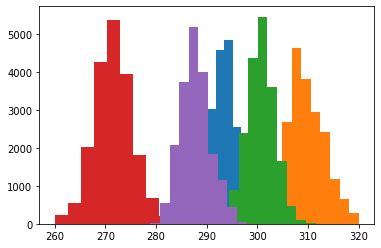

In [168]:
plt.hist(agg_df['met_avg_t'].to_list())
plt.hist(agg_df['met_max_t_max'].to_list())
plt.hist(agg_df['met_max_t_med'].to_list())
plt.hist(agg_df['met_min_t_min'].to_list())
plt.hist(agg_df['met_min_t_med'].to_list())
plt.show()

Different means, but all normally distributed, which is good

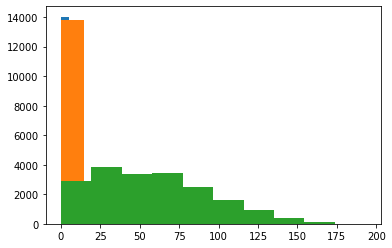

In [169]:
plt.hist(agg_df['met_extreme_cold'].to_list())
plt.hist(agg_df['met_extreme_hot1'].to_list())
plt.hist(agg_df['met_extreme_hot2'].to_list())
plt.show()

Extreme Cold and Hot1 appear to be lognormal, but hot2 appears to be more normal.  Let's graph just hot1 and cold.  Maybe we should add a log term for those, to see if it's more predictive

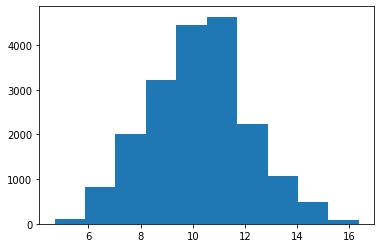

In [170]:
plt.hist(agg_df['met_gdd_mean'].to_list())
plt.show()

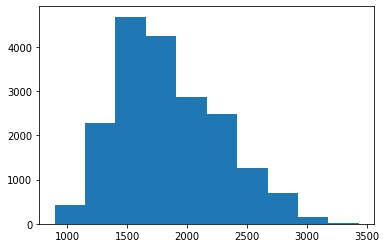

In [171]:
plt.hist(agg_df['met_gdd_sum'].to_list())
plt.show()

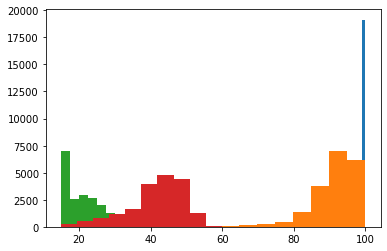

In [172]:
plt.hist(agg_df['met_max_rh_max'].to_list())
plt.hist(agg_df['met_max_rh_med'].to_list())
plt.hist(agg_df['met_min_rh_min'].to_list())
plt.hist(agg_df['met_min_rh_med'].to_list())
plt.show()

They all look a little funky, but the max of the max relative humidity is definitely the most extreme. It looks like it's all 100's, so likely not very useful for prediction :P

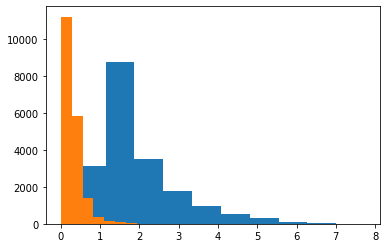

In [173]:
plt.hist(agg_df['met_max_vpd_max'].to_list())
plt.hist(agg_df['met_max_vpd_med'].to_list())
plt.show()

Interestingly, the max of maxes is more normally distributed than the medians.  Possibly log terms will help for both, though

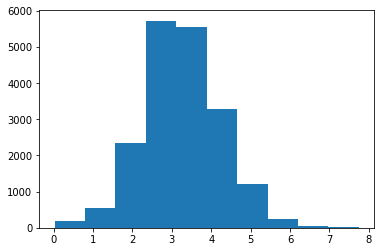

In [174]:
plt.hist(agg_df['met_p_mm'].to_list())
plt.show()

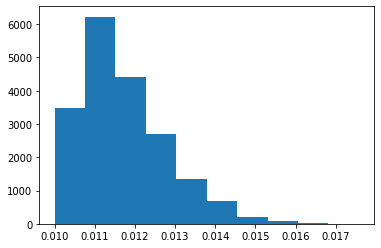

In [175]:
plt.hist(agg_df['met_sh'].to_list())
plt.show()

another log-normal

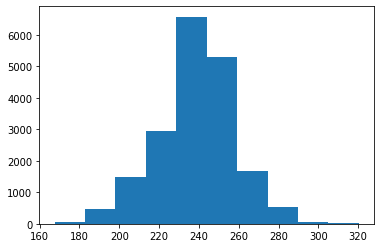

In [176]:
plt.hist(agg_df['met_sr_wm2'].to_list())
plt.show()

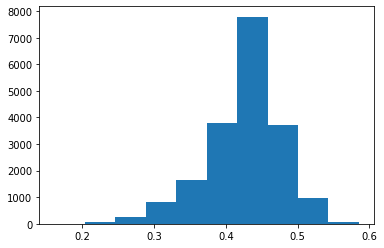

In [177]:
plt.hist(agg_df['mod_evi'].to_list())
plt.show()

some skew, but nothing too extreme..

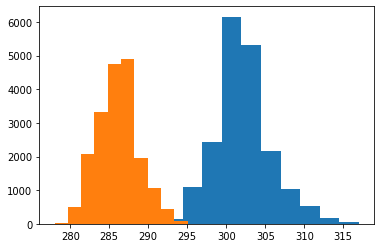

In [178]:
plt.hist(agg_df['mod_lst_day'].to_list())
plt.hist(agg_df['mod_lst_night'].to_list())
plt.show()

Normal-ish, at least

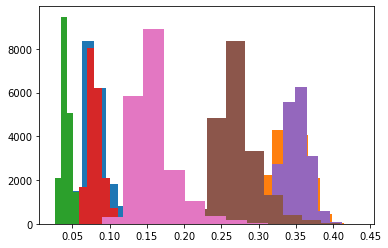

In [179]:
plt.hist(agg_df['mod_nbar_1'].to_list())
plt.hist(agg_df['mod_nbar_2'].to_list())
plt.hist(agg_df['mod_nbar_3'].to_list())
plt.hist(agg_df['mod_nbar_4'].to_list())
plt.hist(agg_df['mod_nbar_5'].to_list())
plt.hist(agg_df['mod_nbar_6'].to_list())
plt.hist(agg_df['mod_nbar_7'].to_list())
plt.show()

They all look pretty normal, which is good

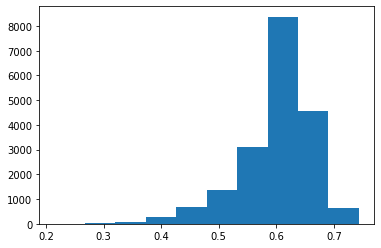

In [180]:
plt.hist(agg_df['mod_ndvi'].to_list())
plt.show()

again, some skew but nothing too extreme

invalid value encountered in greater_equal
invalid value encountered in less_equal


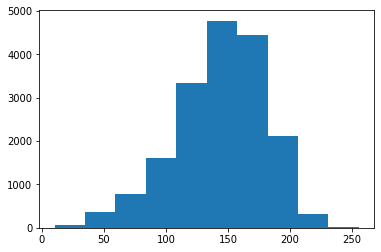

In [181]:
plt.hist(agg_df['yield'].to_list())
plt.show()

In [182]:
log_terms = [
    'met_extreme_cold',
    'met_extreme_hot1',
    'met_max_vpd_max',
    'met_max_vpd_med',
    'met_sh'
]

we store the terms to make iteration easier.

In [183]:
for term in log_terms:
    agg_df[term + '_log'] = [math.log1p(x) for x in agg_df[term]]

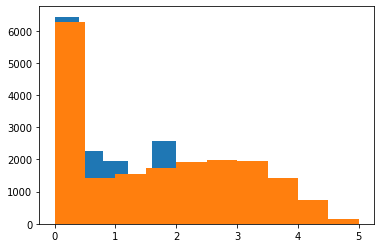

In [184]:
plt.hist(agg_df['met_extreme_cold_log'].to_list())
plt.hist(agg_df['met_extreme_hot1_log'].to_list())
plt.show()

Better, though the 0 lower bound is still messing with the distribution

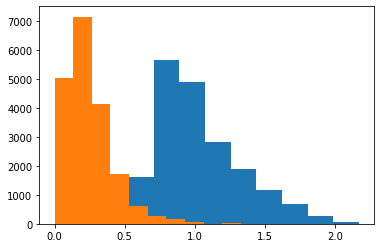

In [185]:
plt.hist(agg_df['met_max_vpd_max_log'].to_list())
plt.hist(agg_df['met_max_vpd_med_log'].to_list())
plt.show()

Much better! Time to build a model.  We'll start simple, with some default terms, just to see how we do.  We'll start with x-val, just to levelset

In [186]:
train_df = agg_df[agg_df['year'] < 2018]

In [187]:
xgData = xg.DMatrix(data = np.array(train_df.drop(['yield','county'], axis = 1)), label = np.array(train_df['yield']))

In [189]:
params = {'objective':'reg:squarederror',  'max_depth':6, 'gamma':1e-3}

xg.cv(params, xgData, num_boost_round = 999, nfold=10,
       metrics={'rmse'}, seed=0, early_stopping_rounds = 20,
       callbacks=[xg.callback.print_evaluation(show_stdv=True)])

[0]	train-rmse:104.506+0.0507336	test-rmse:104.581+0.538827
[1]	train-rmse:74.5298+0.0364231	test-rmse:74.6783+0.4383
[2]	train-rmse:53.8655+0.029233	test-rmse:54.159+0.335177
[3]	train-rmse:39.811+0.0363423	test-rmse:40.2652+0.313442
[4]	train-rmse:30.4553+0.0426991	test-rmse:31.1114+0.304829
[5]	train-rmse:24.4005+0.0672963	test-rmse:25.2706+0.331224
[6]	train-rmse:20.6182+0.077003	test-rmse:21.7499+0.420256
[7]	train-rmse:18.3282+0.0627815	test-rmse:19.6484+0.478977
[8]	train-rmse:16.9096+0.106612	test-rmse:18.4446+0.51239
[9]	train-rmse:16.0275+0.125599	test-rmse:17.7152+0.498508
[10]	train-rmse:15.433+0.130302	test-rmse:17.2879+0.471769
[11]	train-rmse:15.0117+0.119036	test-rmse:16.9968+0.495195
[12]	train-rmse:14.7431+0.10091	test-rmse:16.8178+0.51707
[13]	train-rmse:14.4747+0.13227	test-rmse:16.6648+0.501514
[14]	train-rmse:14.2755+0.113998	test-rmse:16.5638+0.513101
[15]	train-rmse:14.0882+0.10331	test-rmse:16.4597+0.514173
[16]	train-rmse:13.8814+0.107986	test-rmse:16.3597+0.5

[137]	train-rmse:6.80682+0.104455	test-rmse:14.6139+0.525792
[138]	train-rmse:6.77994+0.108097	test-rmse:14.6132+0.526886
[139]	train-rmse:6.75681+0.108561	test-rmse:14.6086+0.529385
[140]	train-rmse:6.73306+0.107342	test-rmse:14.6076+0.528399
[141]	train-rmse:6.69989+0.104017	test-rmse:14.6074+0.526386
[142]	train-rmse:6.67713+0.0993408	test-rmse:14.6088+0.52484
[143]	train-rmse:6.65141+0.0969198	test-rmse:14.6045+0.524661
[144]	train-rmse:6.62011+0.0988542	test-rmse:14.602+0.524129
[145]	train-rmse:6.5952+0.099875	test-rmse:14.6021+0.525216
[146]	train-rmse:6.56566+0.0999907	test-rmse:14.6019+0.526227
[147]	train-rmse:6.54054+0.10034	test-rmse:14.5986+0.527584
[148]	train-rmse:6.50786+0.101769	test-rmse:14.5956+0.531361
[149]	train-rmse:6.48432+0.102694	test-rmse:14.5923+0.529035
[150]	train-rmse:6.46196+0.102635	test-rmse:14.5913+0.530387
[151]	train-rmse:6.44111+0.10343	test-rmse:14.5879+0.533112
[152]	train-rmse:6.41737+0.102577	test-rmse:14.5863+0.529556
[153]	train-rmse:6.3957+0

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,104.505775,0.050734,104.580959,0.538827
1,74.529771,0.036423,74.678302,0.438300
2,53.865466,0.029233,54.159040,0.335177
3,39.811001,0.036342,40.265211,0.313442
4,30.455267,0.042699,31.111401,0.304829
5,24.400516,0.067296,25.270558,0.331224
6,20.618177,0.077003,21.749929,0.420256
7,18.328231,0.062781,19.648448,0.478977
8,16.909641,0.106612,18.444587,0.512390
9,16.027531,0.125599,17.715186,0.498508


In [190]:
params = {'objective':'reg:squarederror',  'max_depth':3, 'gamma':1e-3}

xg.cv(params, xgData, num_boost_round = 999, nfold=10,
       metrics={'rmse'}, seed=0, early_stopping_rounds = 20,
       callbacks=[xg.callback.print_evaluation(show_stdv=True)])

[0]	train-rmse:104.931+0.0514858	test-rmse:104.958+0.580121
[1]	train-rmse:75.3388+0.0334448	test-rmse:75.3652+0.52546
[2]	train-rmse:55.1932+0.0198333	test-rmse:55.2654+0.456612
[3]	train-rmse:41.7913+0.0260283	test-rmse:41.9099+0.431395
[4]	train-rmse:33.0564+0.0392442	test-rmse:33.2032+0.397189
[5]	train-rmse:27.6066+0.0641821	test-rmse:27.7996+0.39087
[6]	train-rmse:24.2458+0.0739149	test-rmse:24.4771+0.380854
[7]	train-rmse:22.2695+0.114216	test-rmse:22.5622+0.377732
[8]	train-rmse:21.0818+0.0954114	test-rmse:21.4188+0.418092
[9]	train-rmse:20.3359+0.0894247	test-rmse:20.7118+0.409488
[10]	train-rmse:19.8575+0.104405	test-rmse:20.2725+0.410504
[11]	train-rmse:19.5106+0.116172	test-rmse:19.964+0.417269
[12]	train-rmse:19.1996+0.118637	test-rmse:19.6606+0.424816
[13]	train-rmse:18.989+0.142656	test-rmse:19.4755+0.410294
[14]	train-rmse:18.7815+0.136347	test-rmse:19.2867+0.419727
[15]	train-rmse:18.6268+0.148295	test-rmse:19.159+0.407652
[16]	train-rmse:18.4762+0.119725	test-rmse:19.

[136]	train-rmse:13.7326+0.0527374	test-rmse:15.8516+0.401315
[137]	train-rmse:13.7153+0.0518932	test-rmse:15.8401+0.400742
[138]	train-rmse:13.6947+0.0545598	test-rmse:15.8293+0.398022
[139]	train-rmse:13.6784+0.0566498	test-rmse:15.8183+0.39693
[140]	train-rmse:13.6599+0.0550196	test-rmse:15.8136+0.401864
[141]	train-rmse:13.6413+0.0541734	test-rmse:15.8087+0.401849
[142]	train-rmse:13.6233+0.0532869	test-rmse:15.7981+0.404695
[143]	train-rmse:13.6037+0.0500411	test-rmse:15.7914+0.405938
[144]	train-rmse:13.5827+0.0471102	test-rmse:15.7807+0.405094
[145]	train-rmse:13.5638+0.0430046	test-rmse:15.77+0.403011
[146]	train-rmse:13.5442+0.0417557	test-rmse:15.759+0.403412
[147]	train-rmse:13.5242+0.0411475	test-rmse:15.7525+0.404354
[148]	train-rmse:13.508+0.0431448	test-rmse:15.7441+0.406398
[149]	train-rmse:13.4904+0.0424177	test-rmse:15.736+0.404381
[150]	train-rmse:13.4776+0.0445084	test-rmse:15.7282+0.406085
[151]	train-rmse:13.4587+0.0430813	test-rmse:15.7218+0.410064
[152]	train-rm

[270]	train-rmse:11.8339+0.0560052	test-rmse:15.1257+0.408926
[271]	train-rmse:11.8207+0.0553998	test-rmse:15.1199+0.40527
[272]	train-rmse:11.8098+0.0557712	test-rmse:15.1156+0.408259
[273]	train-rmse:11.7984+0.0559376	test-rmse:15.1122+0.407983
[274]	train-rmse:11.7896+0.0547835	test-rmse:15.1109+0.402981
[275]	train-rmse:11.7779+0.055312	test-rmse:15.1145+0.402928
[276]	train-rmse:11.7675+0.0559999	test-rmse:15.115+0.404242
[277]	train-rmse:11.7576+0.0580978	test-rmse:15.1164+0.403164
[278]	train-rmse:11.7473+0.0570772	test-rmse:15.1155+0.403712
[279]	train-rmse:11.7358+0.0571957	test-rmse:15.1133+0.404358
[280]	train-rmse:11.7234+0.0557115	test-rmse:15.1083+0.404435
[281]	train-rmse:11.7124+0.055083	test-rmse:15.1021+0.407423
[282]	train-rmse:11.7009+0.0539787	test-rmse:15.0971+0.407363
[283]	train-rmse:11.689+0.0540097	test-rmse:15.0934+0.409257
[284]	train-rmse:11.6787+0.0530811	test-rmse:15.0872+0.406527
[285]	train-rmse:11.6684+0.0522247	test-rmse:15.0861+0.406995
[286]	train-r

[404]	train-rmse:10.6191+0.0567064	test-rmse:14.8163+0.401597
[405]	train-rmse:10.6106+0.0577204	test-rmse:14.8131+0.398531
[406]	train-rmse:10.6024+0.0580477	test-rmse:14.8138+0.399527
[407]	train-rmse:10.5947+0.0574682	test-rmse:14.8128+0.400095
[408]	train-rmse:10.586+0.0574963	test-rmse:14.8116+0.403041
[409]	train-rmse:10.5788+0.0576856	test-rmse:14.8087+0.404443
[410]	train-rmse:10.5717+0.0565837	test-rmse:14.8081+0.403483
[411]	train-rmse:10.5636+0.0558008	test-rmse:14.8067+0.405114
[412]	train-rmse:10.5553+0.0550463	test-rmse:14.8077+0.405428
[413]	train-rmse:10.5478+0.0542591	test-rmse:14.8063+0.408629
[414]	train-rmse:10.5418+0.0542337	test-rmse:14.8079+0.410837
[415]	train-rmse:10.5341+0.053609	test-rmse:14.8064+0.412756
[416]	train-rmse:10.5258+0.0541167	test-rmse:14.806+0.414115
[417]	train-rmse:10.5193+0.0538228	test-rmse:14.8067+0.41347
[418]	train-rmse:10.5119+0.0528409	test-rmse:14.8056+0.413117
[419]	train-rmse:10.5044+0.051996	test-rmse:14.8059+0.413283
[420]	train-r

[538]	train-rmse:9.68891+0.0451735	test-rmse:14.7037+0.402744
[539]	train-rmse:9.68362+0.045777	test-rmse:14.7043+0.40294
[540]	train-rmse:9.67728+0.0463256	test-rmse:14.7031+0.400515
[541]	train-rmse:9.67232+0.0474732	test-rmse:14.7015+0.4003
[542]	train-rmse:9.66529+0.0474465	test-rmse:14.7025+0.399098
[543]	train-rmse:9.6595+0.0469839	test-rmse:14.7014+0.399278
[544]	train-rmse:9.65465+0.0463323	test-rmse:14.7005+0.398954
[545]	train-rmse:9.64852+0.0469644	test-rmse:14.6981+0.396917
[546]	train-rmse:9.64071+0.0467129	test-rmse:14.6961+0.397071
[547]	train-rmse:9.63445+0.0468206	test-rmse:14.6966+0.397236
[548]	train-rmse:9.62738+0.0464667	test-rmse:14.6956+0.396212
[549]	train-rmse:9.62185+0.0463938	test-rmse:14.6962+0.396939
[550]	train-rmse:9.61525+0.0463071	test-rmse:14.6956+0.398901
[551]	train-rmse:9.60812+0.046448	test-rmse:14.6928+0.400816
[552]	train-rmse:9.60336+0.0458511	test-rmse:14.6925+0.402111
[553]	train-rmse:9.59729+0.0463334	test-rmse:14.6915+0.403324
[554]	train-rm

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,104.931429,0.051486,104.957665,0.580121
1,75.338755,0.033445,75.365231,0.525460
2,55.193193,0.019833,55.265376,0.456612
3,41.791268,0.026028,41.909913,0.431395
4,33.056381,0.039244,33.203154,0.397189
5,27.606593,0.064182,27.799568,0.390870
6,24.245823,0.073915,24.477053,0.380854
7,22.269467,0.114216,22.562215,0.377732
8,21.081846,0.095411,21.418836,0.418092
9,20.335891,0.089425,20.711781,0.409488


Looks like max depth of 3 converges much more slowly to slightly worse than max depth of 6.  Let's try some higher depths

In [191]:
params = {'objective':'reg:squarederror',  'max_depth':7, 'gamma':1e-3}

xg.cv(params, xgData, num_boost_round = 999, nfold=10,
       metrics={'rmse'}, seed=0, early_stopping_rounds = 20,
       callbacks=[xg.callback.print_evaluation(show_stdv=True)])

[0]	train-rmse:104.442+0.0526461	test-rmse:104.551+0.541108
[1]	train-rmse:74.3785+0.0361062	test-rmse:74.5846+0.428198
[2]	train-rmse:53.5969+0.0291027	test-rmse:53.9884+0.370982
[3]	train-rmse:39.3778+0.028	test-rmse:40.0717+0.344372
[4]	train-rmse:29.8151+0.0285986	test-rmse:30.8237+0.351696
[5]	train-rmse:23.548+0.0412531	test-rmse:24.9193+0.385863
[6]	train-rmse:19.5531+0.0456899	test-rmse:21.3297+0.435083
[7]	train-rmse:17.0337+0.0717784	test-rmse:19.1788+0.463124
[8]	train-rmse:15.4889+0.0746626	test-rmse:17.9639+0.492587
[9]	train-rmse:14.5172+0.106583	test-rmse:17.2507+0.512767
[10]	train-rmse:13.9137+0.113447	test-rmse:16.8289+0.513254
[11]	train-rmse:13.4427+0.0885063	test-rmse:16.5523+0.517657
[12]	train-rmse:13.1013+0.0955589	test-rmse:16.3679+0.526633
[13]	train-rmse:12.8294+0.128197	test-rmse:16.2118+0.525006
[14]	train-rmse:12.5566+0.101529	test-rmse:16.0918+0.516211
[15]	train-rmse:12.3398+0.0963107	test-rmse:16.0002+0.511976
[16]	train-rmse:12.1279+0.0738355	test-rmse

[136]	train-rmse:4.81443+0.0836919	test-rmse:14.5765+0.474335
[137]	train-rmse:4.78765+0.0818296	test-rmse:14.5754+0.474749
[138]	train-rmse:4.74946+0.084886	test-rmse:14.5691+0.47596
[139]	train-rmse:4.72214+0.0802164	test-rmse:14.5676+0.47713
[140]	train-rmse:4.69887+0.0824631	test-rmse:14.5673+0.480676
[141]	train-rmse:4.67409+0.0839316	test-rmse:14.5663+0.481891
[142]	train-rmse:4.64762+0.0882673	test-rmse:14.5629+0.480384
[143]	train-rmse:4.62327+0.0950206	test-rmse:14.5596+0.480675
[144]	train-rmse:4.59615+0.0826089	test-rmse:14.5619+0.479075
[145]	train-rmse:4.57179+0.0860525	test-rmse:14.5623+0.479309
[146]	train-rmse:4.54801+0.0840767	test-rmse:14.5599+0.480192
[147]	train-rmse:4.52522+0.0803904	test-rmse:14.5574+0.48147
[148]	train-rmse:4.49685+0.0763976	test-rmse:14.5554+0.483165
[149]	train-rmse:4.47603+0.0762788	test-rmse:14.5532+0.480447
[150]	train-rmse:4.44648+0.0721022	test-rmse:14.552+0.481208
[151]	train-rmse:4.42464+0.0781484	test-rmse:14.5521+0.478042
[152]	train-r

[270]	train-rmse:2.44105+0.0437786	test-rmse:14.4874+0.480014
[271]	train-rmse:2.42952+0.0444028	test-rmse:14.4863+0.480708
[272]	train-rmse:2.41628+0.0435382	test-rmse:14.4849+0.480277
[273]	train-rmse:2.40467+0.0430252	test-rmse:14.4846+0.480735
[274]	train-rmse:2.39343+0.0443324	test-rmse:14.4838+0.481359
[275]	train-rmse:2.38418+0.0445952	test-rmse:14.4842+0.480819
[276]	train-rmse:2.37277+0.0446	test-rmse:14.4842+0.48148
[277]	train-rmse:2.35906+0.0445843	test-rmse:14.4832+0.481677
[278]	train-rmse:2.3465+0.0412726	test-rmse:14.4824+0.480298
[279]	train-rmse:2.33644+0.0388833	test-rmse:14.4826+0.480027
[280]	train-rmse:2.32519+0.0417503	test-rmse:14.482+0.47985
[281]	train-rmse:2.31434+0.039999	test-rmse:14.4817+0.480454
[282]	train-rmse:2.30554+0.0413192	test-rmse:14.482+0.480179
[283]	train-rmse:2.29501+0.0396728	test-rmse:14.4815+0.480072
[284]	train-rmse:2.28568+0.0381815	test-rmse:14.4813+0.479703
[285]	train-rmse:2.27441+0.0384823	test-rmse:14.4805+0.479731
[286]	train-rmse:

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,104.442448,0.052646,104.551098,0.541108
1,74.378459,0.036106,74.584603,0.428198
2,53.596886,0.029103,53.988359,0.370982
3,39.377792,0.028000,40.071740,0.344372
4,29.815149,0.028599,30.823747,0.351696
5,23.547961,0.041253,24.919298,0.385863
6,19.553109,0.045690,21.329674,0.435083
7,17.033727,0.071778,19.178778,0.463124
8,15.488924,0.074663,17.963867,0.492587
9,14.517165,0.106583,17.250653,0.512767


In [192]:
params = {'objective':'reg:squarederror',  'max_depth':5, 'gamma':1e-3}

xg.cv(params, xgData, num_boost_round = 999, nfold=10,
       metrics={'rmse'}, seed=0, early_stopping_rounds = 20,
       callbacks=[xg.callback.print_evaluation(show_stdv=True)])

[0]	train-rmse:104.593+0.0502834	test-rmse:104.64+0.576014
[1]	train-rmse:74.7192+0.02779	test-rmse:74.8311+0.452665
[2]	train-rmse:54.2083+0.0334703	test-rmse:54.4032+0.391004
[3]	train-rmse:40.3331+0.0398686	test-rmse:40.5961+0.361406
[4]	train-rmse:31.1641+0.0594599	test-rmse:31.5764+0.356927
[5]	train-rmse:25.2801+0.0732133	test-rmse:25.8457+0.358648
[6]	train-rmse:21.6578+0.0844074	test-rmse:22.3592+0.383114
[7]	train-rmse:19.4591+0.0718667	test-rmse:20.3096+0.431698
[8]	train-rmse:18.1687+0.0709314	test-rmse:19.1343+0.470683
[9]	train-rmse:17.3271+0.0963489	test-rmse:18.3715+0.511329
[10]	train-rmse:16.7877+0.10694	test-rmse:17.9218+0.507202
[11]	train-rmse:16.389+0.0815195	test-rmse:17.6049+0.492327
[12]	train-rmse:16.0913+0.0647617	test-rmse:17.3983+0.522138
[13]	train-rmse:15.8729+0.073231	test-rmse:17.2506+0.493863
[14]	train-rmse:15.6694+0.0626211	test-rmse:17.1224+0.496172
[15]	train-rmse:15.5113+0.0595516	test-rmse:17.0175+0.503524
[16]	train-rmse:15.3667+0.0593841	test-rm

[136]	train-rmse:9.07201+0.0622117	test-rmse:14.7528+0.490846
[137]	train-rmse:9.04948+0.0679855	test-rmse:14.7524+0.490163
[138]	train-rmse:9.02429+0.0678036	test-rmse:14.7509+0.488562
[139]	train-rmse:9.00053+0.0619293	test-rmse:14.7478+0.48818
[140]	train-rmse:8.97629+0.0685516	test-rmse:14.7468+0.48643
[141]	train-rmse:8.94855+0.066437	test-rmse:14.746+0.487849
[142]	train-rmse:8.92217+0.066699	test-rmse:14.7455+0.484865
[143]	train-rmse:8.89811+0.0685168	test-rmse:14.7436+0.481808
[144]	train-rmse:8.8725+0.0690655	test-rmse:14.7387+0.478121
[145]	train-rmse:8.84953+0.0634968	test-rmse:14.7343+0.481116
[146]	train-rmse:8.83003+0.0656858	test-rmse:14.7325+0.479845
[147]	train-rmse:8.80551+0.0618238	test-rmse:14.7271+0.480913
[148]	train-rmse:8.78441+0.0646548	test-rmse:14.7296+0.479754
[149]	train-rmse:8.76078+0.063645	test-rmse:14.73+0.478195
[150]	train-rmse:8.73973+0.0648156	test-rmse:14.7256+0.4807
[151]	train-rmse:8.71222+0.0599354	test-rmse:14.7227+0.478714
[152]	train-rmse:8.

[270]	train-rmse:6.5985+0.0473347	test-rmse:14.5336+0.471921
[271]	train-rmse:6.58376+0.0474907	test-rmse:14.5328+0.473119
[272]	train-rmse:6.57073+0.0478336	test-rmse:14.5318+0.472907
[273]	train-rmse:6.55872+0.0470798	test-rmse:14.5329+0.475295
[274]	train-rmse:6.54679+0.0484676	test-rmse:14.5306+0.474178
[275]	train-rmse:6.53079+0.0514369	test-rmse:14.5291+0.474831
[276]	train-rmse:6.51784+0.0506851	test-rmse:14.5304+0.474406
[277]	train-rmse:6.50352+0.0508106	test-rmse:14.5298+0.474024
[278]	train-rmse:6.4892+0.0511742	test-rmse:14.5282+0.474245
[279]	train-rmse:6.47337+0.0546328	test-rmse:14.5274+0.476494
[280]	train-rmse:6.46022+0.0548581	test-rmse:14.5259+0.476574
[281]	train-rmse:6.44601+0.0538158	test-rmse:14.5236+0.477096
[282]	train-rmse:6.42822+0.0510572	test-rmse:14.5223+0.477678
[283]	train-rmse:6.41497+0.0493713	test-rmse:14.5203+0.479416
[284]	train-rmse:6.40112+0.0477485	test-rmse:14.521+0.476203
[285]	train-rmse:6.38674+0.0498519	test-rmse:14.5217+0.475042
[286]	train

[404]	train-rmse:5.00872+0.0477511	test-rmse:14.4616+0.466308
[405]	train-rmse:4.99975+0.0440344	test-rmse:14.4635+0.466535
[406]	train-rmse:4.99056+0.0438236	test-rmse:14.464+0.466557
[407]	train-rmse:4.98302+0.0443406	test-rmse:14.4631+0.46629
[408]	train-rmse:4.97269+0.0447659	test-rmse:14.4633+0.466792
[409]	train-rmse:4.96118+0.0442689	test-rmse:14.4615+0.467021
[410]	train-rmse:4.94836+0.0473394	test-rmse:14.4626+0.466377
[411]	train-rmse:4.93981+0.0485797	test-rmse:14.4627+0.466501
[412]	train-rmse:4.93188+0.0482239	test-rmse:14.4638+0.466972
[413]	train-rmse:4.92242+0.0494226	test-rmse:14.4656+0.466202
[414]	train-rmse:4.91308+0.047215	test-rmse:14.4658+0.466186
[415]	train-rmse:4.90569+0.0473672	test-rmse:14.4654+0.466046
[416]	train-rmse:4.89627+0.0473097	test-rmse:14.4647+0.467388
[417]	train-rmse:4.88498+0.045775	test-rmse:14.464+0.467254
[418]	train-rmse:4.875+0.0437607	test-rmse:14.4647+0.468329
[419]	train-rmse:4.86605+0.0422794	test-rmse:14.464+0.468614
[420]	train-rmse

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,104.592825,0.050283,104.639883,0.576014
1,74.719169,0.027790,74.831141,0.452665
2,54.208284,0.033470,54.403195,0.391004
3,40.333142,0.039869,40.596050,0.361406
4,31.164086,0.059460,31.576449,0.356927
5,25.280053,0.073213,25.845687,0.358648
6,21.657779,0.084407,22.359152,0.383114
7,19.459108,0.071867,20.309561,0.431698
8,18.168737,0.070931,19.134322,0.470683
9,17.327089,0.096349,18.371507,0.511329


Depth 6 really seems to be a sweet spot.  Let's see if we can futz with the gamma to modify the delta between Test and Train RMSE

In [193]:
params = {'objective':'reg:squarederror',  'max_depth':6, 'gamma':1}

xg.cv(params, xgData, num_boost_round = 999, nfold=10,
       metrics={'rmse'}, seed=0, early_stopping_rounds = 20,
       callbacks=[xg.callback.print_evaluation(show_stdv=True)])

[0]	train-rmse:104.506+0.0507343	test-rmse:104.581+0.538828
[1]	train-rmse:74.5298+0.0364246	test-rmse:74.6783+0.4383
[2]	train-rmse:53.8655+0.0292333	test-rmse:54.159+0.335177
[3]	train-rmse:39.811+0.0363431	test-rmse:40.2652+0.313442
[4]	train-rmse:30.4553+0.0426989	test-rmse:31.1114+0.304829
[5]	train-rmse:24.4005+0.0672964	test-rmse:25.2706+0.331224
[6]	train-rmse:20.6182+0.077003	test-rmse:21.7499+0.420256
[7]	train-rmse:18.3282+0.0627819	test-rmse:19.6484+0.478977
[8]	train-rmse:16.9096+0.106611	test-rmse:18.4446+0.51239
[9]	train-rmse:16.0275+0.125599	test-rmse:17.7152+0.498507
[10]	train-rmse:15.433+0.130302	test-rmse:17.2879+0.47177
[11]	train-rmse:15.0117+0.119036	test-rmse:16.9968+0.495195
[12]	train-rmse:14.7431+0.10091	test-rmse:16.8179+0.517105
[13]	train-rmse:14.4747+0.132261	test-rmse:16.6649+0.501556
[14]	train-rmse:14.2755+0.113989	test-rmse:16.5639+0.513145
[15]	train-rmse:14.0882+0.103304	test-rmse:16.4598+0.514221
[16]	train-rmse:13.8814+0.107983	test-rmse:16.3597+

[136]	train-rmse:6.79777+0.0662261	test-rmse:14.611+0.551391
[137]	train-rmse:6.77254+0.0692288	test-rmse:14.6111+0.552101
[138]	train-rmse:6.74987+0.0686915	test-rmse:14.6108+0.555304
[139]	train-rmse:6.72671+0.0715476	test-rmse:14.6106+0.552575
[140]	train-rmse:6.70054+0.0699448	test-rmse:14.6071+0.554286
[141]	train-rmse:6.67358+0.0648157	test-rmse:14.6054+0.55257
[142]	train-rmse:6.64384+0.0623249	test-rmse:14.5971+0.550031
[143]	train-rmse:6.61954+0.0592386	test-rmse:14.5964+0.547214
[144]	train-rmse:6.58864+0.057043	test-rmse:14.5941+0.549376
[145]	train-rmse:6.56573+0.0592023	test-rmse:14.5914+0.548076
[146]	train-rmse:6.54125+0.0596007	test-rmse:14.5892+0.551403
[147]	train-rmse:6.51296+0.0554005	test-rmse:14.5859+0.54977
[148]	train-rmse:6.49312+0.058055	test-rmse:14.5868+0.547709
[149]	train-rmse:6.47101+0.0610382	test-rmse:14.5877+0.546354
[150]	train-rmse:6.44621+0.0631086	test-rmse:14.587+0.545489
[151]	train-rmse:6.41908+0.0718134	test-rmse:14.5857+0.544254
[152]	train-rm

[269]	train-rmse:4.23887+0.0521534	test-rmse:14.4967+0.577044
[270]	train-rmse:4.22647+0.0507228	test-rmse:14.4957+0.578104
[271]	train-rmse:4.21433+0.0530954	test-rmse:14.4953+0.578569
[272]	train-rmse:4.20114+0.0520341	test-rmse:14.4958+0.577733
[273]	train-rmse:4.18528+0.0519928	test-rmse:14.4961+0.578223
[274]	train-rmse:4.17005+0.0520964	test-rmse:14.497+0.578103
[275]	train-rmse:4.15396+0.0550321	test-rmse:14.4981+0.577671
[276]	train-rmse:4.14222+0.0554107	test-rmse:14.4974+0.578136
[277]	train-rmse:4.12887+0.0559682	test-rmse:14.4964+0.577825
[278]	train-rmse:4.1188+0.0536957	test-rmse:14.4974+0.578424
[279]	train-rmse:4.10735+0.051926	test-rmse:14.4962+0.579045
[280]	train-rmse:4.0946+0.0530435	test-rmse:14.4953+0.576831
[281]	train-rmse:4.07996+0.0485121	test-rmse:14.494+0.576978
[282]	train-rmse:4.06456+0.0491696	test-rmse:14.4935+0.576407
[283]	train-rmse:4.05348+0.0502996	test-rmse:14.4944+0.576925
[284]	train-rmse:4.04007+0.049803	test-rmse:14.4943+0.576587
[285]	train-rm

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,104.505774,0.050734,104.580959,0.538828
1,74.529772,0.036425,74.678301,0.438300
2,53.865466,0.029233,54.159040,0.335177
3,39.811001,0.036343,40.265211,0.313442
4,30.455267,0.042699,31.111402,0.304829
5,24.400517,0.067296,25.270558,0.331224
6,20.618177,0.077003,21.749929,0.420256
7,18.328231,0.062782,19.648448,0.478977
8,16.909641,0.106611,18.444587,0.512390
9,16.027532,0.125599,17.715186,0.498507


In [194]:
params = {'objective':'reg:squarederror',  'max_depth':6, 'gamma':1e-1}

xg.cv(params, xgData, num_boost_round = 999, nfold=10,
       metrics={'rmse'}, seed=0, early_stopping_rounds = 20,
       callbacks=[xg.callback.print_evaluation(show_stdv=True)])

[0]	train-rmse:104.506+0.0507333	test-rmse:104.581+0.538829
[1]	train-rmse:74.5298+0.0364219	test-rmse:74.6783+0.4383
[2]	train-rmse:53.8655+0.0292338	test-rmse:54.159+0.335177
[3]	train-rmse:39.811+0.0363422	test-rmse:40.2652+0.313441
[4]	train-rmse:30.4553+0.0426995	test-rmse:31.1114+0.304829
[5]	train-rmse:24.4005+0.0672965	test-rmse:25.2706+0.331224
[6]	train-rmse:20.6182+0.0770028	test-rmse:21.7499+0.420256
[7]	train-rmse:18.3282+0.0627813	test-rmse:19.6484+0.478977
[8]	train-rmse:16.9096+0.106611	test-rmse:18.4446+0.512389
[9]	train-rmse:16.0275+0.125599	test-rmse:17.7152+0.498507
[10]	train-rmse:15.433+0.130302	test-rmse:17.2879+0.471769
[11]	train-rmse:15.0117+0.119036	test-rmse:16.9968+0.495195
[12]	train-rmse:14.7431+0.100911	test-rmse:16.8179+0.517105
[13]	train-rmse:14.4747+0.132268	test-rmse:16.6649+0.501557
[14]	train-rmse:14.2755+0.113997	test-rmse:16.5639+0.513146
[15]	train-rmse:14.0882+0.103308	test-rmse:16.4598+0.51422
[16]	train-rmse:13.8814+0.107984	test-rmse:16.35

[137]	train-rmse:6.84475+0.118176	test-rmse:14.6236+0.537134
[138]	train-rmse:6.81+0.119087	test-rmse:14.6233+0.536468
[139]	train-rmse:6.78259+0.113903	test-rmse:14.6177+0.538901
[140]	train-rmse:6.76044+0.114032	test-rmse:14.6191+0.538216
[141]	train-rmse:6.73171+0.110285	test-rmse:14.6196+0.539484
[142]	train-rmse:6.70816+0.107197	test-rmse:14.6229+0.540512
[143]	train-rmse:6.68468+0.105562	test-rmse:14.6204+0.539442
[144]	train-rmse:6.65633+0.103076	test-rmse:14.6185+0.540229
[145]	train-rmse:6.6333+0.105743	test-rmse:14.6158+0.543383
[146]	train-rmse:6.60514+0.104226	test-rmse:14.6163+0.544925
[147]	train-rmse:6.58184+0.105935	test-rmse:14.6135+0.543565
[148]	train-rmse:6.55451+0.110008	test-rmse:14.6111+0.543145
[149]	train-rmse:6.53288+0.104876	test-rmse:14.6105+0.544186
[150]	train-rmse:6.51137+0.103513	test-rmse:14.6097+0.544455
[151]	train-rmse:6.48359+0.106671	test-rmse:14.6074+0.54148
[152]	train-rmse:6.45507+0.10415	test-rmse:14.6021+0.537574
[153]	train-rmse:6.43089+0.102

[272]	train-rmse:4.25387+0.102212	test-rmse:14.4908+0.523943
[273]	train-rmse:4.24035+0.101102	test-rmse:14.4911+0.525841
[274]	train-rmse:4.22765+0.0982947	test-rmse:14.4914+0.524362
[275]	train-rmse:4.21717+0.0987373	test-rmse:14.4919+0.523933
[276]	train-rmse:4.20482+0.0959456	test-rmse:14.4914+0.524349
[277]	train-rmse:4.18754+0.0927252	test-rmse:14.4924+0.525301
[278]	train-rmse:4.17692+0.0919891	test-rmse:14.4909+0.525849
[279]	train-rmse:4.16367+0.0945552	test-rmse:14.4909+0.527258
[280]	train-rmse:4.15339+0.0944738	test-rmse:14.492+0.527837
[281]	train-rmse:4.13996+0.0927494	test-rmse:14.4906+0.52802
[282]	train-rmse:4.12779+0.0907827	test-rmse:14.4919+0.52792
[283]	train-rmse:4.11731+0.0906264	test-rmse:14.4909+0.528585
[284]	train-rmse:4.10689+0.0920874	test-rmse:14.4914+0.528442
[285]	train-rmse:4.09623+0.0929298	test-rmse:14.4896+0.529126
[286]	train-rmse:4.07954+0.0964896	test-rmse:14.4897+0.530433
[287]	train-rmse:4.07075+0.0978685	test-rmse:14.4889+0.529638
[288]	train-r

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,104.505775,0.050733,104.580957,0.538829
1,74.529772,0.036422,74.678300,0.438300
2,53.865465,0.029234,54.159041,0.335177
3,39.811001,0.036342,40.265211,0.313441
4,30.455268,0.042699,31.111402,0.304829
5,24.400517,0.067296,25.270558,0.331224
6,20.618177,0.077003,21.749930,0.420256
7,18.328231,0.062781,19.648448,0.478977
8,16.909641,0.106611,18.444587,0.512389
9,16.027532,0.125599,17.715186,0.498507


In [195]:
params = {'objective':'reg:squarederror',  'max_depth':6, 'gamma':1e1}

xg.cv(params, xgData, num_boost_round = 999, nfold=10,
       metrics={'rmse'}, seed=0, early_stopping_rounds = 20,
       callbacks=[xg.callback.print_evaluation(show_stdv=True)])

[0]	train-rmse:104.506+0.0507346	test-rmse:104.581+0.538827
[1]	train-rmse:74.5298+0.0364252	test-rmse:74.6783+0.4383
[2]	train-rmse:53.8655+0.0292333	test-rmse:54.159+0.335177
[3]	train-rmse:39.811+0.0363432	test-rmse:40.2652+0.313442
[4]	train-rmse:30.4553+0.0426992	test-rmse:31.1114+0.304829
[5]	train-rmse:24.4005+0.067296	test-rmse:25.2706+0.331224
[6]	train-rmse:20.6182+0.0770034	test-rmse:21.7499+0.420256
[7]	train-rmse:18.3282+0.0627854	test-rmse:19.6484+0.478963
[8]	train-rmse:16.9096+0.106614	test-rmse:18.4446+0.512382
[9]	train-rmse:16.0273+0.125401	test-rmse:17.7154+0.498592
[10]	train-rmse:15.4327+0.130065	test-rmse:17.2872+0.471756
[11]	train-rmse:15.0155+0.121377	test-rmse:16.9983+0.496555
[12]	train-rmse:14.7458+0.102363	test-rmse:16.8236+0.51971
[13]	train-rmse:14.4672+0.126417	test-rmse:16.6701+0.504566
[14]	train-rmse:14.2668+0.110217	test-rmse:16.5553+0.508437
[15]	train-rmse:14.0752+0.102302	test-rmse:16.4459+0.509664
[16]	train-rmse:13.883+0.100704	test-rmse:16.361

[137]	train-rmse:6.81221+0.0651076	test-rmse:14.6023+0.498322
[138]	train-rmse:6.7887+0.0646271	test-rmse:14.6028+0.501922
[139]	train-rmse:6.76238+0.0646545	test-rmse:14.6054+0.50002
[140]	train-rmse:6.73133+0.0606195	test-rmse:14.6014+0.502351
[141]	train-rmse:6.70479+0.0638827	test-rmse:14.6038+0.502483
[142]	train-rmse:6.68436+0.0633173	test-rmse:14.6019+0.505199
[143]	train-rmse:6.66335+0.0651179	test-rmse:14.5992+0.503036
[144]	train-rmse:6.63228+0.0610421	test-rmse:14.5915+0.499737
[145]	train-rmse:6.60803+0.0637375	test-rmse:14.5899+0.501156
[146]	train-rmse:6.57751+0.0616274	test-rmse:14.5832+0.503833
[147]	train-rmse:6.5499+0.0592763	test-rmse:14.5795+0.503002
[148]	train-rmse:6.52349+0.0623964	test-rmse:14.5765+0.499882
[149]	train-rmse:6.4963+0.06223	test-rmse:14.573+0.500024
[150]	train-rmse:6.47358+0.0638211	test-rmse:14.5694+0.500301
[151]	train-rmse:6.44561+0.0548921	test-rmse:14.5658+0.500642
[152]	train-rmse:6.41917+0.0536259	test-rmse:14.5637+0.505145
[153]	train-rms

[271]	train-rmse:4.24264+0.0638779	test-rmse:14.4986+0.5162
[272]	train-rmse:4.2285+0.0595784	test-rmse:14.4987+0.515698
[273]	train-rmse:4.21487+0.0557441	test-rmse:14.4986+0.513893
[274]	train-rmse:4.20102+0.0526784	test-rmse:14.4985+0.514291
[275]	train-rmse:4.1866+0.0513909	test-rmse:14.4974+0.512912
[276]	train-rmse:4.17684+0.0499973	test-rmse:14.4984+0.513011
[277]	train-rmse:4.16537+0.0484906	test-rmse:14.4982+0.513316
[278]	train-rmse:4.15182+0.0499024	test-rmse:14.4971+0.512082
[279]	train-rmse:4.14192+0.0547453	test-rmse:14.4982+0.511075
[280]	train-rmse:4.12721+0.0566583	test-rmse:14.4971+0.511859
[281]	train-rmse:4.11242+0.0578974	test-rmse:14.4969+0.513854
[282]	train-rmse:4.09696+0.0539245	test-rmse:14.498+0.515496
[283]	train-rmse:4.0814+0.0547391	test-rmse:14.4985+0.515826
[284]	train-rmse:4.06524+0.0548031	test-rmse:14.4979+0.51558
[285]	train-rmse:4.05238+0.0523789	test-rmse:14.4971+0.515089
[286]	train-rmse:4.04137+0.0520753	test-rmse:14.4973+0.514973


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,104.505776,0.050735,104.580959,0.538827
1,74.529771,0.036425,74.678301,0.438300
2,53.865466,0.029233,54.159040,0.335177
3,39.811001,0.036343,40.265210,0.313442
4,30.455268,0.042699,31.111401,0.304829
5,24.400517,0.067296,25.270558,0.331224
6,20.618177,0.077003,21.749929,0.420256
7,18.328227,0.062785,19.648416,0.478963
8,16.909643,0.106614,18.444594,0.512382
9,16.027332,0.125401,17.715358,0.498592


looks like a depth of 6, gamma of 1 is pretty good.  You may ask why I'm not doing a grid search, my fear with grid searches is that they tend to overfit, even with cross-validation, as there are too many parameters to tune.  I try to be intuitive about why and how I'm adjusting my parameters, and end up in a space I believe is 'good enough', rather than 'perfect'

next step is to look at a more defined test/train set.  Ultimately, we'll be using the parameters we used for cross-validation, but we'll hold out 2017 and build on 2003-2016.  This is likely better than straight cross-validation, as we have a true out-of-sample test set.

In [196]:
test_df = train_df[train_df['year'] == 2017]
train_df = train_df[train_df['year'] < 2017]

In [197]:
xgTrain = xg.DMatrix(data = np.array(train_df.drop(['yield','county'], axis = 1)), label = np.array(train_df['yield']))
xgTest = xg.DMatrix(data = np.array(test_df.drop(['yield','county'], axis = 1)), label = np.array(test_df['yield']))

In [198]:
params = {'objective':'reg:squarederror',  'max_depth':6, 'gamma':1}

model = xg.train(
    params,
    xgTrain,
    num_boost_round=999,
    evals=[(xgTest, "Test")],
    early_stopping_rounds=20
)

[0]	Test-rmse:123.329
Will train until Test-rmse hasn't improved in 20 rounds.
[1]	Test-rmse:90.3857
[2]	Test-rmse:67.0184
[3]	Test-rmse:50.5272
[4]	Test-rmse:39.4843
[5]	Test-rmse:31.6685
[6]	Test-rmse:26.5078
[7]	Test-rmse:23.1508
[8]	Test-rmse:20.8463
[9]	Test-rmse:19.3594
[10]	Test-rmse:18.5643
[11]	Test-rmse:17.9931
[12]	Test-rmse:17.6499
[13]	Test-rmse:17.3218
[14]	Test-rmse:17.0166
[15]	Test-rmse:16.8946
[16]	Test-rmse:16.8369
[17]	Test-rmse:16.758
[18]	Test-rmse:16.666
[19]	Test-rmse:16.6406
[20]	Test-rmse:16.6287
[21]	Test-rmse:16.6258
[22]	Test-rmse:16.4473
[23]	Test-rmse:16.4129
[24]	Test-rmse:16.2924
[25]	Test-rmse:16.2799
[26]	Test-rmse:16.243
[27]	Test-rmse:16.238
[28]	Test-rmse:16.2145
[29]	Test-rmse:16.0412
[30]	Test-rmse:15.9751
[31]	Test-rmse:16.1655
[32]	Test-rmse:16.1383
[33]	Test-rmse:16.2729
[34]	Test-rmse:16.2292
[35]	Test-rmse:16.2829
[36]	Test-rmse:16.3174
[37]	Test-rmse:16.2741
[38]	Test-rmse:16.1759
[39]	Test-rmse:16.1848
[40]	Test-rmse:16.166
[41]	Test-rmse:

Note here that our RMSE for out-of-sample is significantly higher than with Xval.  We can try to tweak params a bit, but part of this is that the xval model has access to yearly trends in a way this one does not.  Let's look at feature importances to get a sense for what our model is doing

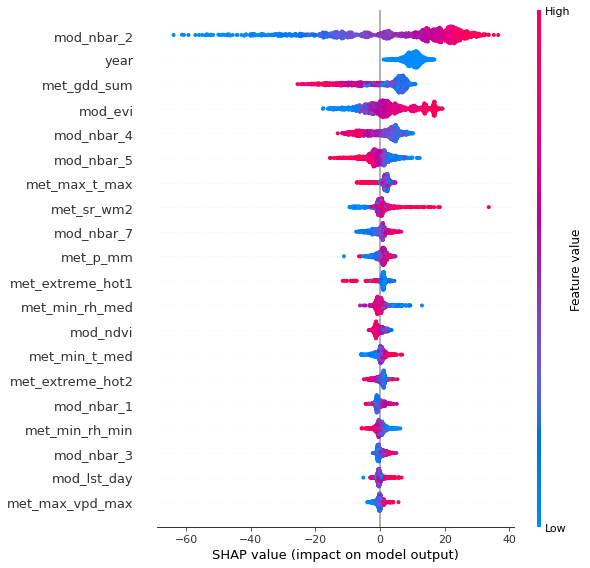

In [199]:
shap_values = shap.TreeExplainer(model).shap_values(test_df.drop(['yield', 'county'], axis = 1))
shap.summary_plot(shap_values, test_df.drop(['yield', 'county'], axis = 1))

It looks like the year is very significant... this may be somewhat confounding our results, let's try removing it, and see what happens with out models.  We'll just use the test/train split again

In [200]:
xgTrain_no_year = xg.DMatrix(data = np.array(train_df.drop(['yield','county', 'year'], axis = 1)), label = np.array(train_df['yield']))
xgTest_no_year = xg.DMatrix(data = np.array(test_df.drop(['yield','county', 'year'], axis = 1)), label = np.array(test_df['yield']))

In [201]:
params = {'objective':'reg:squarederror',  'max_depth':6, 'gamma':1}

model_no_year = xg.train(
    params,
    xgTrain_no_year,
    num_boost_round=999,
    evals=[(xgTest_no_year, "Test")],
    early_stopping_rounds=20
)

[0]	Test-rmse:125.655
Will train until Test-rmse hasn't improved in 20 rounds.
[1]	Test-rmse:94.0407
[2]	Test-rmse:71.8132
[3]	Test-rmse:56.2245
[4]	Test-rmse:45.0191
[5]	Test-rmse:37.6902
[6]	Test-rmse:32.2906
[7]	Test-rmse:28.6385
[8]	Test-rmse:26.3078
[9]	Test-rmse:24.3756
[10]	Test-rmse:23.3009
[11]	Test-rmse:22.5911
[12]	Test-rmse:21.9194
[13]	Test-rmse:21.5987
[14]	Test-rmse:21.2031
[15]	Test-rmse:20.8744
[16]	Test-rmse:20.6185
[17]	Test-rmse:20.5132
[18]	Test-rmse:20.4226
[19]	Test-rmse:20.3601
[20]	Test-rmse:20.2899
[21]	Test-rmse:20.1433
[22]	Test-rmse:20.1227
[23]	Test-rmse:20.1253
[24]	Test-rmse:20.1843
[25]	Test-rmse:20.1164
[26]	Test-rmse:20.0417
[27]	Test-rmse:20.0658
[28]	Test-rmse:20.04
[29]	Test-rmse:19.9894
[30]	Test-rmse:19.9833
[31]	Test-rmse:19.938
[32]	Test-rmse:19.9386
[33]	Test-rmse:19.8846
[34]	Test-rmse:19.8606
[35]	Test-rmse:19.7688
[36]	Test-rmse:19.732
[37]	Test-rmse:19.7064
[38]	Test-rmse:19.699
[39]	Test-rmse:19.6873
[40]	Test-rmse:19.6693
[41]	Test-rmse:

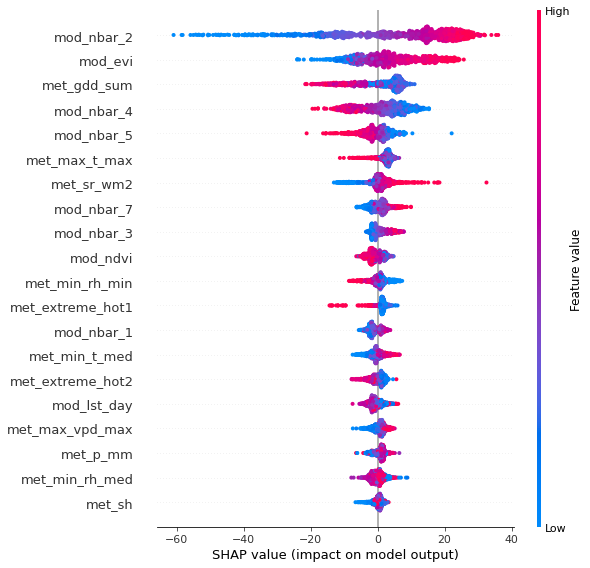

In [202]:
shap_values = shap.TreeExplainer(model_no_year).shap_values(test_df.drop(['yield', 'county', 'year'], axis = 1))
shap.summary_plot(shap_values, test_df.drop(['yield', 'county', 'year'], axis = 1))

Looks like our shap values aren't that different, so we'll keep the model with year since it's more predictive on the test set, even though the year for the test set is out-of-sample.  Let's calculate relative rmse, just so we get a sense of how much we're off by, since '16' doesn't mean much to me

In [203]:
predyields_no_year = model_no_year.predict(xgTest_no_year)
rel_errors = (predyields_no_year - np.array(test_df['yield']))/np.array(test_df['yield'])
math.sqrt(np.mean(rel_errors**2))

0.12289882483242166

In [204]:
predyields = model.predict(xgTest)
rel_errors = (predyields - np.array(test_df['yield']))/np.array(test_df['yield'])
math.sqrt(np.mean(rel_errors**2))

0.10505622954078622

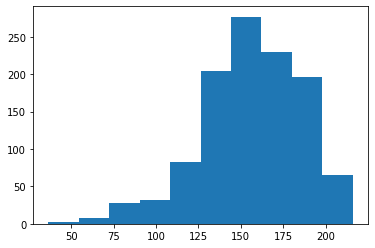

In [205]:
plt.hist(predyields_no_year)
plt.show()

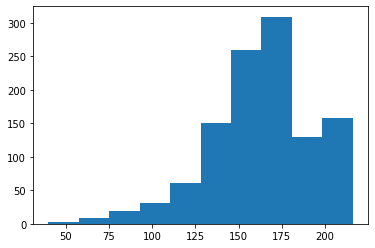

In [206]:
plt.hist(predyields)
plt.show()

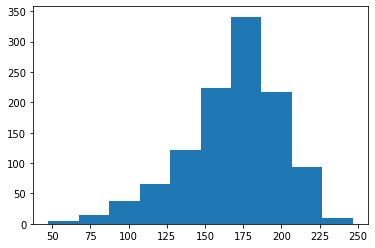

In [207]:
plt.hist(test_df['yield'].to_list())
plt.show()

Looks like we're off by about 10% at the county level (12% without using the year), and we have some weird bumps at the top end.  It's possible this is an artifact of the way year is used for prediction.  Let's see how we fare when we aggregating counties up to a single year, and compare with the yearly result for the US

In [208]:
year_data = common_data[common_data['year'] == 2017]
denom = 0
runsum = 0
for i,county in enumerate(test_df['county']):
    cropland = int(year_data[year_data['adm2_code'] == county]['area_harvested_obs'])
    pred_yield = predyields[i]
    denom += cropland
    runsum += cropland*pred_yield

runsum/denom


176.34339501986372

In [209]:
annual_yields[annual_yields['year'] == 2017]

,year,yield
27,2017,176.6


looks like we're only off by .3/176.6 at the national level, or .16%, so our model is clearly calibrated well!  Let's do some level-setting with a linear regression, just to make sure we've got something good

In [210]:
ridge = sklearn.linear_model.Ridge()

ridge.fit(train_df.drop(['yield', 'county'], axis = 1), train_df['yield'])

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [211]:
ridgePreds = ridge.predict(test_df.drop(['yield', 'county'], axis = 1))

In [212]:
rel_errors = (ridgePreds - np.array(test_df['yield']))/np.array(test_df['yield'])
math.sqrt(np.mean(rel_errors**2))

0.13108549813170536

In [213]:
year_data = common_data[common_data['year'] == 2017]
denom = 0
runsum = 0
for i,county in enumerate(test_df['county']):
    cropland = int(year_data[year_data['adm2_code'] == county]['area_harvested_obs'])
    pred_yield = ridgePreds[i]
    denom += cropland
    runsum += cropland*pred_yield

runsum/denom


176.40343343348044

Looks like our linear model is calibrated slightly better (.11% to .16%), but is off by ~13% of the actual yield, instead of ~10.5% for our Xgboost model.  XGboost is pretty clearly better.